# RNN in Pytorch

In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


### Data

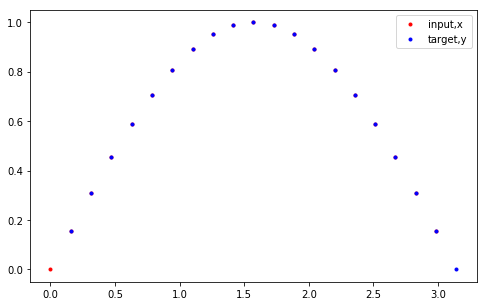

In [49]:
plt.figure(figsize=(8,5))

# how many time steps in  one batch
seq_length = 20

# generate evenly spaced data pts with sin()
time_steps = np.linspace(0,np.pi, seq_length+1)
data = np.sin(time_steps)
data.resize((seq_length+1,1))

# time series data
x = data[:-1]
y = data[1:]
plt.plot(time_steps[:-1],x, 'r.', label='input,x')
plt.plot(time_steps[1:],y, 'b.', label='target,y')
plt.legend(loc='best')
plt.show()

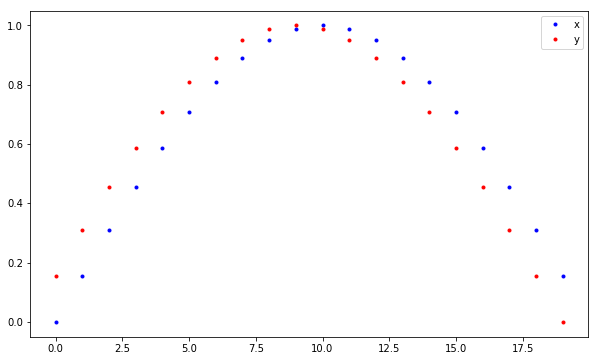

In [54]:
plt.figure(figsize=(10,6))
plt.plot(x,'b.', label='x')
plt.plot(y,'r.',label='y')
plt.legend(loc='best')
plt.show()

### RNN Archtecture

In [63]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        # batch_first= True: output such that dim=0 is batch size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        # hidden = (n_layers, batch_size, hidden_dim)
        # r_out = (batch_size, time_step, hidden_size)
        
        batch_size = x.size(0)
        
        
        r_out, hidden = self.rnn(x,hidden)
        r_out = r_out.view(-1, self.hidden_dim)
        
        output = self.fc(r_out)
        
        return output, hidden
        
        

In [106]:
# to check dimension
test_run = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2) 

# generate evenly spaced data pts with sin()
time_steps = np.linspace(0,np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length,1))

test_input = torch.Tensor(data).unsqueeze(0)
print('Input size', test_input.size())

test_out, test_h = test_run(test_input, None)
print('Output size:', test_out.size())
print('Hidden state size: ', test_h.size())

Input size torch.Size([1, 20, 1])
Output size: torch.Size([20, 1])
Hidden state size:  torch.Size([2, 1, 10])


### Train

In [84]:
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 2

rnn = RNN(input_size, output_size, hidden_dim, n_layers)

In [85]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

In [97]:
def train( rnn, n_steps, print_every):
    hidden = None
    for batch_i, step in enumerate(range(n_steps)):
        time_steps = np.linspace(step*np.pi, (step+1)*np.pi, seq_length+1)
        data = np.sin(time_steps)
        data.resize(seq_length+1, 1)
        x = data[:-1]
        # output is also nois
        y = data[1:] + np.random.randn(x.shape[0], x.shape[1])    
        
        x_tensor = torch.Tensor(x).unsqueeze(0)
        y_tensor = torch.Tensor(y)
        
        prediction, hidden = rnn(x_tensor, hidden)
            
        # this way we dont have to backpropgate through entire history
        hidden = hidden.data
            
        loss = criterion(prediction, y_tensor)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
            
        if batch_i%print_every == 0:
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.', label='real')
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 
                     'b.', label='predicted')
            plt.legend(loc='best')
            plt.show()
    return rnn
            

Loss:  0.9083459973335266


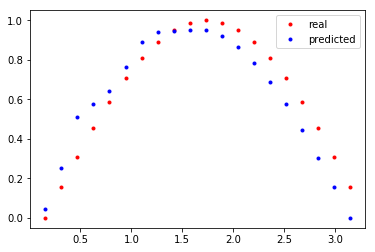

Loss:  0.9107268452644348


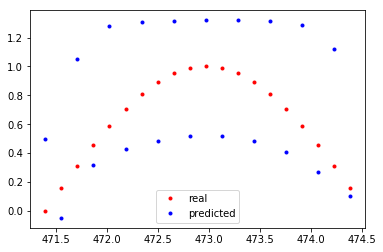

Loss:  1.0288368463516235


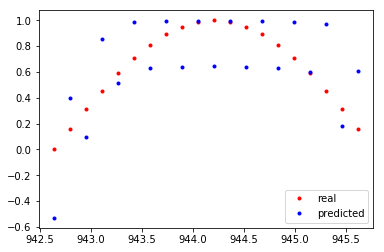

Loss:  1.414021372795105


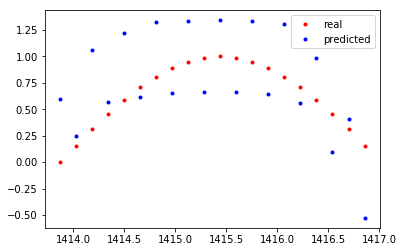

Loss:  0.8213236331939697


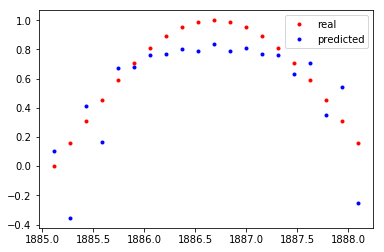

In [98]:
n_steps = 750
print_every = 150

trained_rnn = train(rnn, n_steps, print_every)